In [7]:
## Preparation

# Import the necessary libraries
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np
import os
import optuna


## Global Var

dataset_path = os.getcwd() + '/dataset/classified'

class_labels = ["Normal", "Cataract"]

In [8]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Check the CUDA version PyTorch is using
print(torch.cuda.current_device()) # Check CUDA device used

True
12.6
0


In [9]:
# Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load Dataset
ds = datasets.ImageFolder(root=dataset_path, transform=transform)

indices = list(range(len(ds)))
# labels = [ds.targets[i] for i in indices]

# Split into train and test dataset
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_ds = Subset(ds, train_indices)
test_ds = Subset(ds, test_indices)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

total_samples  = len(train_ds) + len(test_ds)

print(f"Train size: {(len(train_ds) / total_samples) * 100:.2f}%, Test size: {(len(test_ds)/total_samples)*100:.2f}%")
print(f"Total samples: {total_samples}, Train size: {len(train_ds)}, Test size: {len(test_ds)}")

Train size: 79.98%, Test size: 20.02%
Total samples: 1159, Train size: 927, Test size: 232


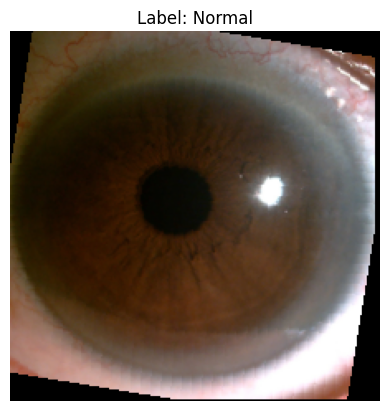

In [10]:
def denormalize(tensor, mean=None, std=None):
    if std is None:
        std = [0.5, 0.5, 0.5]
    if mean is None:
        mean = [0.5, 0.5, 0.5]
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean  # Reverse normalization

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Select one image
img = images[0]
label = labels[0].item()

# Denormalize image
img = denormalize(img)

# Convert from Tensor (C, H, W) to NumPy (H, W, C)
img = np.transpose(img.numpy(), (1, 2, 0))

# Plot the image
plt.imshow(img)
plt.title(f"Label: {class_labels[label]}")  # Display label
plt.axis("off")
plt.show()

In [11]:
# Optuna Hyperparameter

best_train_losses = []
best_train_accuracies = []

all_preds = []
all_labels = []

def objective(trial: optuna.Trial) -> float:
    device_name = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device_name}")

    # We will use cuda
    device = torch.device(device_name)

    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    num_epochs = trial.suggest_int(name="num_epochs", low=5, high=10, step=1)

    model = models.efficientnet_b0(progress=True, weights=models.EfficientNet_B0_Weights.DEFAULT)

    for param in model.features[:-3].parameters():
        param.requires_grad = False

    number_of_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(number_of_features, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, 1)
    ).to(device)

    model.to(device)

    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    scaler = GradScaler(device=device_name)

    train_losses = []
    train_accuracies = []

    epoch_acc = 0.0

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(images)  # No autocast
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = correct / total * 100

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    if not best_train_losses or epoch_acc > max(best_train_accuracies):
        best_train_losses.clear()
        best_train_accuracies.clear()
        best_train_losses.extend(train_losses)
        best_train_accuracies.extend(train_accuracies)

    # Evaluate Model
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct / total * 100
    print(f"🎯 Test Accuracy: {test_acc:.2f}%")

    return test_acc

In [12]:
study = optuna.create_study(direction="maximize", study_name="hyperparam cataract classifier", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10, show_progress_bar=True)

acc = best_train_accuracies[-1]

print("\nBest Hyperparameters:", study.best_params)
print("\nBest Train Losses:", best_train_losses)
print("\nBest Train Accuracies:", best_train_accuracies)
print("\nAccuracy:", acc)

[I 2025-03-12 23:37:39,855] A new study created in memory with name: hyperparam cataract classifier


Training on device cuda
Epoch [1/8], Loss: 0.4954, Accuracy: 76.05%
Epoch [2/8], Loss: 0.2427, Accuracy: 92.02%
Epoch [3/8], Loss: 0.1608, Accuracy: 94.50%
Epoch [4/8], Loss: 0.0933, Accuracy: 96.66%
Epoch [5/8], Loss: 0.0915, Accuracy: 97.09%
Epoch [6/8], Loss: 0.0801, Accuracy: 97.09%
Epoch [7/8], Loss: 0.0594, Accuracy: 97.95%
Epoch [8/8], Loss: 0.0371, Accuracy: 99.14%


[I 2025-03-12 23:40:26,320] Trial 0 finished with value: 92.24137931034483 and parameters: {'lr': 0.0002847471837262809, 'dropout': 0.38481696017336675, 'optimizer': 'Adam', 'num_epochs': 8}. Best is trial 0 with value: 92.24137931034483.


🎯 Test Accuracy: 92.24%
Training on device cuda
Epoch [1/6], Loss: 0.3502, Accuracy: 83.28%
Epoch [2/6], Loss: 0.2001, Accuracy: 92.23%
Epoch [3/6], Loss: 0.1408, Accuracy: 94.28%
Epoch [4/6], Loss: 0.1333, Accuracy: 95.15%
Epoch [5/6], Loss: 0.1101, Accuracy: 95.58%
Epoch [6/6], Loss: 0.0817, Accuracy: 96.66%


[I 2025-03-12 23:42:27,163] Trial 1 finished with value: 92.24137931034483 and parameters: {'lr': 0.0012251458420946602, 'dropout': 0.4811621377756683, 'optimizer': 'Adam', 'num_epochs': 6}. Best is trial 0 with value: 92.24137931034483.


🎯 Test Accuracy: 92.24%
Training on device cuda
Epoch [1/9], Loss: 0.6739, Accuracy: 67.75%
Epoch [2/9], Loss: 0.6659, Accuracy: 69.04%
Epoch [3/9], Loss: 0.6554, Accuracy: 70.98%
Epoch [4/9], Loss: 0.6487, Accuracy: 70.66%
Epoch [5/9], Loss: 0.6440, Accuracy: 70.66%
Epoch [6/9], Loss: 0.6403, Accuracy: 70.66%
Epoch [7/9], Loss: 0.6359, Accuracy: 70.66%
Epoch [8/9], Loss: 0.6347, Accuracy: 70.66%
Epoch [9/9], Loss: 0.6297, Accuracy: 70.66%


[I 2025-03-12 23:45:30,400] Trial 2 finished with value: 75.0 and parameters: {'lr': 0.00036121640022307433, 'dropout': 0.3341847129434399, 'optimizer': 'SGD', 'num_epochs': 9}. Best is trial 0 with value: 92.24137931034483.


🎯 Test Accuracy: 75.00%
Training on device cuda
Epoch [1/10], Loss: 0.4818, Accuracy: 77.56%
Epoch [2/10], Loss: 0.2297, Accuracy: 90.29%
Epoch [3/10], Loss: 0.2100, Accuracy: 92.99%
Epoch [4/10], Loss: 0.1413, Accuracy: 95.25%
Epoch [5/10], Loss: 0.1416, Accuracy: 95.04%
Epoch [6/10], Loss: 0.1045, Accuracy: 95.36%
Epoch [7/10], Loss: 0.0790, Accuracy: 97.52%
Epoch [8/10], Loss: 0.0677, Accuracy: 96.98%
Epoch [9/10], Loss: 0.0484, Accuracy: 98.17%
Epoch [10/10], Loss: 0.0581, Accuracy: 97.84%


[I 2025-03-12 23:49:00,747] Trial 3 finished with value: 95.6896551724138 and parameters: {'lr': 0.009099968471501121, 'dropout': 0.4042295201143873, 'optimizer': 'Adam', 'num_epochs': 10}. Best is trial 3 with value: 95.6896551724138.


🎯 Test Accuracy: 95.69%
Training on device cuda
Epoch [1/10], Loss: 0.6634, Accuracy: 61.92%
Epoch [2/10], Loss: 0.5692, Accuracy: 70.66%
Epoch [3/10], Loss: 0.4984, Accuracy: 70.77%
Epoch [4/10], Loss: 0.4246, Accuracy: 72.28%
Epoch [5/10], Loss: 0.3747, Accuracy: 79.50%
Epoch [6/10], Loss: 0.3404, Accuracy: 85.87%
Epoch [7/10], Loss: 0.3110, Accuracy: 88.35%
Epoch [8/10], Loss: 0.2898, Accuracy: 90.40%
Epoch [9/10], Loss: 0.2826, Accuracy: 91.15%
Epoch [10/10], Loss: 0.2754, Accuracy: 91.05%


[I 2025-03-12 23:52:19,415] Trial 4 finished with value: 90.51724137931035 and parameters: {'lr': 0.008185922989659042, 'dropout': 0.4344064875940791, 'optimizer': 'SGD', 'num_epochs': 10}. Best is trial 3 with value: 95.6896551724138.


🎯 Test Accuracy: 90.52%
Training on device cuda
Epoch [1/8], Loss: 0.6932, Accuracy: 48.76%
Epoch [2/8], Loss: 0.6259, Accuracy: 70.66%
Epoch [3/8], Loss: 0.5713, Accuracy: 70.87%
Epoch [4/8], Loss: 0.5306, Accuracy: 70.87%
Epoch [5/8], Loss: 0.4928, Accuracy: 71.09%
Epoch [6/8], Loss: 0.4776, Accuracy: 71.74%
Epoch [7/8], Loss: 0.4747, Accuracy: 72.38%
Epoch [8/8], Loss: 0.4551, Accuracy: 73.25%


[I 2025-03-12 23:55:02,351] Trial 5 finished with value: 75.86206896551724 and parameters: {'lr': 0.0028259564682997745, 'dropout': 0.3814551976960846, 'optimizer': 'SGD', 'num_epochs': 8}. Best is trial 3 with value: 95.6896551724138.


🎯 Test Accuracy: 75.86%
Training on device cuda
Epoch [1/8], Loss: 0.3952, Accuracy: 81.12%
Epoch [2/8], Loss: 0.1782, Accuracy: 93.31%
Epoch [3/8], Loss: 0.1377, Accuracy: 94.28%
Epoch [4/8], Loss: 0.0982, Accuracy: 96.66%
Epoch [5/8], Loss: 0.0912, Accuracy: 97.09%
Epoch [6/8], Loss: 0.0530, Accuracy: 98.27%
Epoch [7/8], Loss: 0.0470, Accuracy: 98.06%
Epoch [8/8], Loss: 0.0331, Accuracy: 98.92%


[I 2025-03-12 23:57:41,480] Trial 6 finished with value: 93.96551724137932 and parameters: {'lr': 0.0008080712436933715, 'dropout': 0.3823312753137752, 'optimizer': 'Adam', 'num_epochs': 8}. Best is trial 3 with value: 95.6896551724138.


🎯 Test Accuracy: 93.97%
Training on device cuda
Epoch [1/8], Loss: 0.6557, Accuracy: 67.64%
Epoch [2/8], Loss: 0.5810, Accuracy: 73.25%
Epoch [3/8], Loss: 0.4898, Accuracy: 77.13%
Epoch [4/8], Loss: 0.4137, Accuracy: 83.17%
Epoch [5/8], Loss: 0.3619, Accuracy: 88.24%
Epoch [6/8], Loss: 0.3272, Accuracy: 91.26%
Epoch [7/8], Loss: 0.3041, Accuracy: 90.61%
Epoch [8/8], Loss: 0.2934, Accuracy: 90.94%


[I 2025-03-13 00:00:23,318] Trial 7 finished with value: 91.37931034482759 and parameters: {'lr': 4.6754509254085204e-05, 'dropout': 0.3441531298540923, 'optimizer': 'Adam', 'num_epochs': 8}. Best is trial 3 with value: 95.6896551724138.


🎯 Test Accuracy: 91.38%
Training on device cuda
Epoch [1/8], Loss: 0.6757, Accuracy: 65.37%
Epoch [2/8], Loss: 0.6679, Accuracy: 69.15%
Epoch [3/8], Loss: 0.6613, Accuracy: 70.66%
Epoch [4/8], Loss: 0.6571, Accuracy: 71.41%
Epoch [5/8], Loss: 0.6530, Accuracy: 70.33%
Epoch [6/8], Loss: 0.6478, Accuracy: 71.20%
Epoch [7/8], Loss: 0.6430, Accuracy: 70.77%
Epoch [8/8], Loss: 0.6417, Accuracy: 70.55%


[I 2025-03-13 00:03:09,403] Trial 8 finished with value: 75.43103448275862 and parameters: {'lr': 0.00028623139890639134, 'dropout': 0.2861665108591502, 'optimizer': 'SGD', 'num_epochs': 8}. Best is trial 3 with value: 95.6896551724138.


🎯 Test Accuracy: 75.43%
Training on device cuda
Epoch [1/10], Loss: 0.3891, Accuracy: 81.34%
Epoch [2/10], Loss: 0.2431, Accuracy: 90.40%
Epoch [3/10], Loss: 0.1748, Accuracy: 92.02%
Epoch [4/10], Loss: 0.1072, Accuracy: 96.22%
Epoch [5/10], Loss: 0.1087, Accuracy: 96.55%
Epoch [6/10], Loss: 0.0934, Accuracy: 95.58%
Epoch [7/10], Loss: 0.0835, Accuracy: 97.52%
Epoch [8/10], Loss: 0.0700, Accuracy: 97.20%
Epoch [9/10], Loss: 0.0653, Accuracy: 97.41%
Epoch [10/10], Loss: 0.0556, Accuracy: 97.73%


[I 2025-03-13 00:06:37,334] Trial 9 finished with value: 95.25862068965517 and parameters: {'lr': 0.00254994284595387, 'dropout': 0.4951214958384545, 'optimizer': 'Adam', 'num_epochs': 10}. Best is trial 3 with value: 95.6896551724138.


🎯 Test Accuracy: 95.26%

Best Hyperparameters: {'lr': 0.009099968471501121, 'dropout': 0.4042295201143873, 'optimizer': 'Adam', 'num_epochs': 10}

Best Train Losses: [0.49542625149091085, 0.24273917973041534, 0.1607811912894249, 0.09331042071183522, 0.09146203435957431, 0.08012558047970136, 0.05938451600571473, 0.037052383894721666]

Best Train Accuracies: [76.05177993527508, 92.01725997842503, 94.49838187702265, 96.65587918015103, 97.0873786407767, 97.0873786407767, 97.95037756202805, 99.13700107874865]

Accuracy: 99.13700107874865


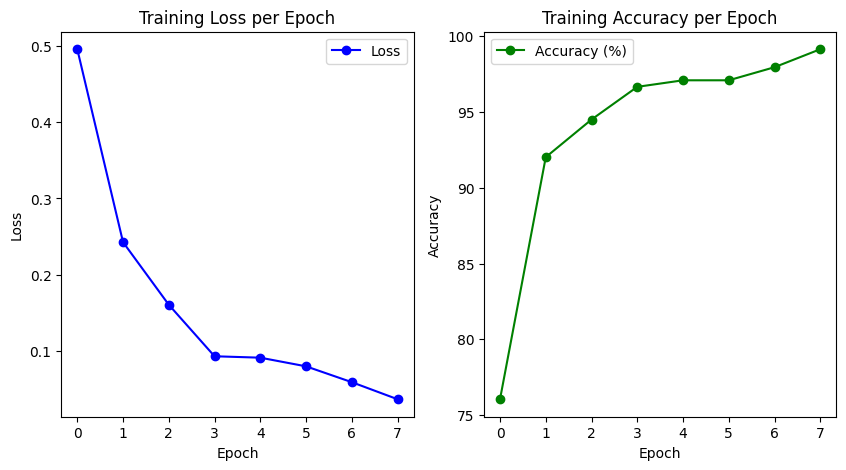

In [13]:
plt.figure(figsize=(10, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label="Loss", marker="o", linestyle="-", color="b")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(best_train_accuracies, label="Accuracy (%)", marker="o", linestyle="-", color="g")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()

plt.show()

Accuracy: 99.14%
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      1740
         1.0       0.87      0.60      0.71       580

    accuracy                           0.88      2320
   macro avg       0.88      0.78      0.82      2320
weighted avg       0.88      0.88      0.87      2320



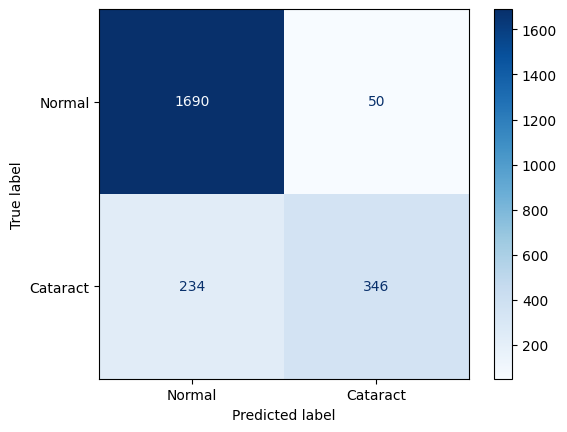

In [14]:
conf_matrix = confusion_matrix(np.array(all_labels), np.array(all_preds))
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap=plt.cm.Blues)

print(f"Accuracy: {acc:.2f}%")

cr = classification_report(np.array(all_labels), np.array(all_preds))
print(cr)

In [15]:
# # save
# output_model_path = f"output/checkpoint-{test_acc}-80x20-aug.pth"
# output_model_path = f"output/checkpoint-{test_acc}-70x30-aug.pth"
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict()
# }, output_model_path)

In [16]:
# checkpoint = torch.load("checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# model.eval()